Overall goal of this notebook is to calculate the following properties :
* Lattice Parameter
* Radial Distribution Function
* Cohesive Energy
* Vacancy Formation Energy
* Migration Energy Barrier 
* Bulk Modulus 
* Melting Point *WIP* 

This paper : https://journals-aps-org.libproxy.mit.edu/prb/abstract/10.1103/PhysRevB.100.144105 (Check the repository for the downloaded PDF called PhysRevB.100.144105.pdf)

Table III compares the properties from Experiment, DFT, and GAP (another ML potential). We will calculate the properties using an EAM potential and our Allegro Potential and then repopulate the graph.

For this work, I want you to make an updated table like Table III in the ANS Summary : https://docs.google.com/document/d/1ISeaC8hF1FIhqBRFQbN9ZoNDwKtq4UmX/edit?usp=sharing&ouid=110359223362956173506&rtpof=true&sd=true The table should go in the "Validation of our Allegro MLIP" Section.

# Libraries

In [10]:
import numpy as np 
import matplotlib.pyplot as plt
import os, sys 
from ase.build import bulk, make_supercell
from ase.optimize.precon import PreconLBFGS
from ase.calculators.eam import EAM 
from nequip.ase import NequIPCalculator
from ase.filters import FrechetCellFilter

## General Functions

In [12]:

def make_struc(alat, element='W', crystal_structure = 'bcc', cubic = True, supercell_size = 1):
    """
    Creates the crystal structure using ASE.
    :param alat: Lattice parameter in angstrom
    :return: structure object converted from ase
    """
    #unitcell = crystal('Ag', [(0, 0, 0)], spacegroup=225, cellpar=[alat, alat, alat, 90, 90, 90])
    unitcell = bulk(element, crystalstructure=crystal_structure, a=alat, cubic = cubic)
    multiplier = np.identity(3) * supercell_size 
    ase_supercell = make_supercell(unitcell, multiplier)
    return ase_supercell  

def relax(atoms, calculator, fmax, num_steps, relax_cell = False):
    """
    Relax the structure using the given calculator
    :param atoms: ASE atoms object
    :param calculator: ASE calculator object
    :param fmax: Maximum force tolerance for relaxation
    :param num_steps: Maximum number of steps for relaxation
    :return: relaxed ASE atoms object
    """
    new_atoms = atoms.copy()
    new_atoms.calc = calculator
    if relax_cell:
        ecf = FrechetCellFilter(new_atoms)
        dyn = PreconLBFGS(ecf, use_armijo=True)
    else:
        dyn = PreconLBFGS(new_atoms, use_armijo=True)
    dyn.run(fmax=fmax, steps=num_steps)
    return new_atoms


# Calculate Lattice Parameter

Here we calculate the lattice parameter. Compare this to the Experimental, DFT, and GAP results

## Functions

In [13]:
def lattice_scan(alat_list, calculator):
    """
    Scan the lattice parameter and calculate the energy
    :param alat_list: List of lattice parameters
    :param calculator: ASE calculator object
    :return: list of energies
    """
    energies = []
    for alat in alat_list:
        atoms = make_struc(alat)
        atoms.calc = calculator
        energy = atoms.get_potential_energy()
        energies.append(energy)
    return energies

## RUn the Code

In [14]:
# define the lattice parameters to scan over
alat_list = np.linspace(2.75, 3.5, 50)

# Define the calculators 
eam_path = '../Potentials/w_eam2.fs'
eam_calculator = EAM(potential=eam_path)

allegro_path = '../Potentials/w-ef.pth'
allegro_calculator = NequIPCalculator.from_deployed_model(model_path=allegro_path, species_to_type_name = {'W':'W'}, device='cpu')

/opt/homebrew/Caskroom/miniforge/base/envs/allegro/lib/python3.10/site-packages/nequip/utils/_global_options.py:95: UserWarning: Do NOT manually set PYTORCH_JIT_USE_NNC_NOT_NVFUSER=0 unless you know exactly what you're doing!
  warnings.warn(


In [15]:
# calculate the energies for each 
eam_energies = lattice_scan(alat_list, eam_calculator)
allegro_energies = lattice_scan(alat_list, allegro_calculator)
eam_a_lat = round(alat_list[np.argmin(eam_energies)],3)
allegro_a_lat = round(alat_list[np.argmin(allegro_energies)],3)

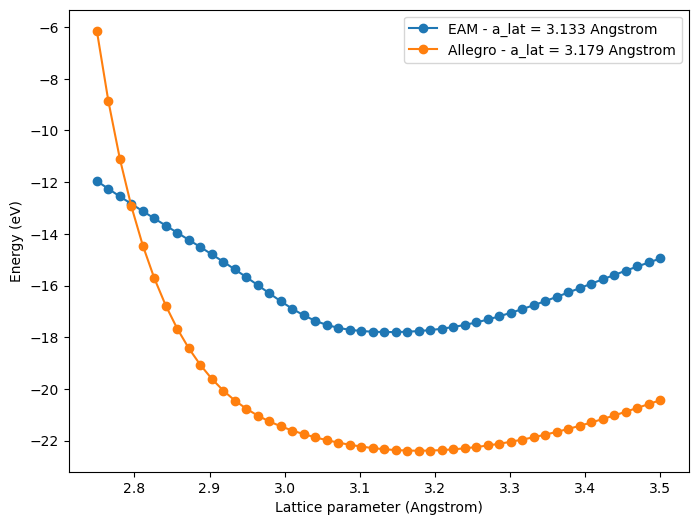

In [16]:
plt.figure(figsize=(8,6))
plt.plot(alat_list, eam_energies, 'o-', label=f'EAM - a_lat = {round(alat_list[np.argmin(eam_energies)], 3)} Angstrom')
plt.plot(alat_list, allegro_energies, 'o-', label=f'Allegro - a_lat = {round(alat_list[np.argmin(allegro_energies)], 3)} Angstrom')
plt.xlabel('Lattice parameter (Angstrom)')
plt.ylabel('Energy (eV)')
plt.legend()
plt.show()

# Calculate the Radial Distribution Function

In this section you will calculate the radial distribution functions of the EAM and the Allegro potentials, this is a good way to show how well the potentials match one another. Since neither of these potentials can calculate the stress tensor it's not the most useful, but it's normally good to calculate this. 

The Radial Distribution Function (RDF) give the probably of you seeing an atom at a certain distance from the center. If we were to compare the RDF of a DFT simulation and our predictive model, then we could see how well our model moves atoms in a similar manner to DFT (accurate quantum mechanics method)

While this doesn't go in the table, it's a good thing to add to the appendix and calculate.

## Functions

In [17]:
import numpy as np
from ase import Atoms
from ase.neighborlist import NeighborList

def calculate_rdf(atoms, r_max, n_bins):
    """
    Calculate the radial distribution function (RDF) for a given structure.

    :param atoms: ASE Atoms object representing the structure.
    :param r_max: Maximum distance to consider for the RDF.
    :param n_bins: Number of bins for the RDF histogram.
    :return: Bin edges and RDF values as numpy arrays.
    """
    # Get the number of atoms and the volume of the cell
    num_atoms = len(atoms)
    volume = atoms.get_volume()

    # Create the neighbor list with a cutoff for the maximum distance
    cutoffs = [r_max / 2.0] * num_atoms
    neighbor_list = NeighborList(cutoffs, self_interaction=False, bothways=True)
    neighbor_list.update(atoms)

    # Prepare the histogram bins
    bin_edges = np.linspace(0, r_max, n_bins + 1)
    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    rdf = np.zeros(n_bins)

    # Calculate pair distances and update RDF histogram
    for i in range(num_atoms):
        indices, offsets = neighbor_list.get_neighbors(i)
        for j, offset in zip(indices, offsets):
            displacement = atoms.positions[j] + np.dot(offset, atoms.get_cell()) - atoms.positions[i]
            distance = np.linalg.norm(displacement)
            if distance < r_max:
                bin_index = np.searchsorted(bin_edges, distance) - 1
                rdf[bin_index] += 2  # Count each pair once

    # Normalize RDF
    shell_volumes = 4.0 / 3.0 * np.pi * (bin_edges[1:]**3 - bin_edges[:-1]**3)
    number_density = num_atoms / volume
    rdf /= (shell_volumes * number_density * num_atoms)

    return bin_centers, rdf




## Run the Code

/opt/homebrew/Caskroom/miniforge/base/envs/allegro/lib/python3.10/site-packages/ase/optimize/precon/lbfgs.py:133: UserWarning: The system is likely too small to benefit from the standard preconditioner, hence it is disabled. To re-enable preconditioning, call `PreconLBFGS` by explicitly providing the kwarg `precon`
  warnings.warn('The system is likely too small to benefit from '


PreconLBFGS:   0  17:08:38     -480.051676       0.3917
PreconLBFGS:   1  17:08:38     -480.133976       0.1123
PreconLBFGS:   2  17:08:39     -480.140407       0.0310
PreconLBFGS:   3  17:08:39     -480.141032       0.0125
PreconLBFGS:   4  17:08:40     -480.141117       0.0037
PreconLBFGS:   0  17:08:40     -604.271105       0.5967
PreconLBFGS:   1  17:08:40     -604.386435       0.1518
PreconLBFGS:   2  17:08:41     -604.396786       0.0563
PreconLBFGS:   3  17:08:41     -604.398477       0.0240
PreconLBFGS:   4  17:08:41     -604.398828       0.0091


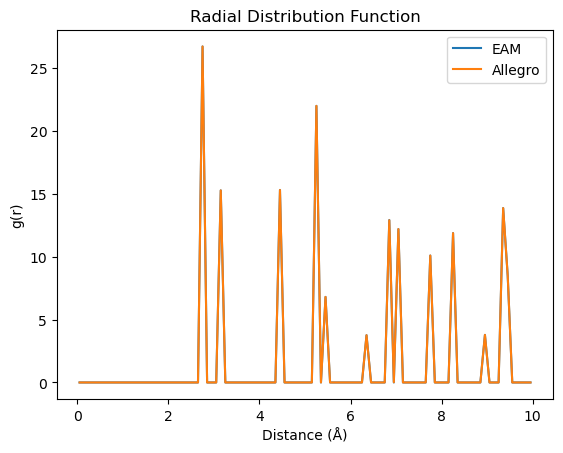

In [18]:
# Example usage
exp_alat = 3.1652  # Experimental lattice parameter for copper in Angstroms
# Create a bulk copper structure
tungsten = make_struc(alat = exp_alat, element='W', crystal_structure = 'bcc', cubic = True, supercell_size = 3)

tungsten.rattle(stdev=0.01)

# define the calculators 
# eam 
eam_path = '../Potentials/w_eam2.fs'
eam_calculator = EAM(potential=eam_path)

# define the allegro calculator
allegro_path = '../Potentials/w-ef.pth'
allegro_calculator = NequIPCalculator.from_deployed_model(model_path=allegro_path, species_to_type_name = {'W':'W'}, device='cpu')

# Relax the structure
tungsten_eam = relax(tungsten, eam_calculator, fmax=0.01, num_steps=100)
tungsten_allegro = relax(tungsten, allegro_calculator, fmax=0.01, num_steps=100)

# Calculate the RDF
r_max = 10.0  # Maximum distance in Angstroms
n_bins = 100  # Number of bins
eam_r, eam_g_r = calculate_rdf(tungsten_eam, r_max, n_bins)
allegro_r, allegro_g_r = calculate_rdf(tungsten_allegro, r_max, n_bins)

# Plot the RDF
plt.plot(eam_r, eam_g_r, label = 'EAM')
plt.plot(allegro_r, allegro_g_r, label = 'Allegro')
plt.xlabel('Distance (Å)')
plt.ylabel('g(r)')
plt.title('Radial Distribution Function')
plt.legend()
plt.show()

# Calculate the Cohesive Energy

## Functions

In [19]:
def cohesive_energy(atoms, e_isolated, calculator):
    """
    Calculate the cohesive energy of the atoms object
    :param atoms: ASE atoms object
    :param calculator: ASE calculator object
    :return: cohesive energy in eV
    """
    new_atoms = atoms.copy()
    new_atoms.calc = calculator
    energy = new_atoms.get_potential_energy()
    natoms = len(atoms)
    cohesive_energy = (energy -  e_isolated) / natoms
    return cohesive_energy

## Run The Functions

In [20]:
# define the calculators 
eam_path = '../Potentials/w_eam2.fs'
eam_calculator = EAM(potential=eam_path)

allegro_path = '../Potentials/w-ef.pth'
allegro_calculator = NequIPCalculator.from_deployed_model(model_path=allegro_path, species_to_type_name = {'W':'W'}, device='cpu')

In [21]:
# use the experimental lattice parameter
exp_alat = 3.165

# calculate the energy of the isolated atom 
isolated_atom_eam = make_struc(exp_alat, supercell_size=1, cubic=False)
isolated_atom_eam.calc = eam_calculator
e_isolated_eam = isolated_atom_eam.get_potential_energy()

isolated_atom_allegro = make_struc(exp_alat, supercell_size=1, cubic=False)
isolated_atom_allegro.calc = allegro_calculator
e_isolated_allegro = isolated_atom_allegro.get_potential_energy()

In [22]:
# Calculate the cohesive energy for each as a function of supercell size
supercell_sizes = np.arange(1, 7) 
eam_cohesive_energies = []
allegro_cohesive_energies = []
for supercell_size in supercell_sizes:
    atoms_eam = make_struc(exp_alat, supercell_size=supercell_size, cubic=False)
    atoms_allegro = make_struc(exp_alat, supercell_size=supercell_size, cubic=False)
    eam_cohesive_energy = cohesive_energy(atoms_eam, e_isolated_eam, eam_calculator)
    allegro_cohesive_energy = cohesive_energy(atoms_allegro, e_isolated_allegro, allegro_calculator)
    eam_cohesive_energies.append(eam_cohesive_energy)
    allegro_cohesive_energies.append(allegro_cohesive_energy)

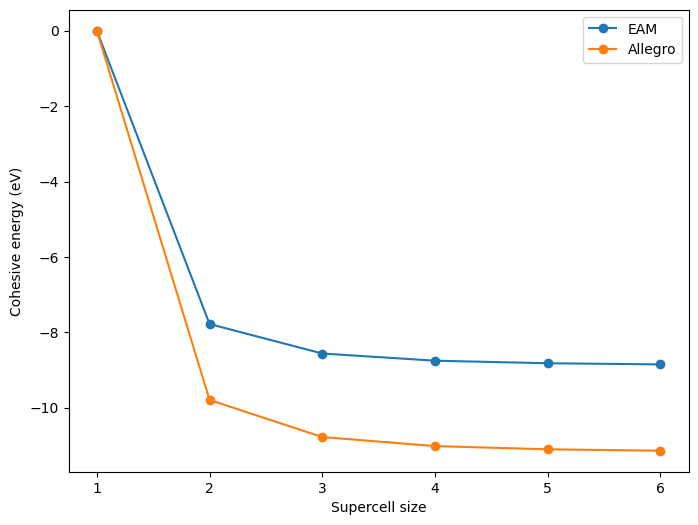

In [23]:
# plot the cohesive energy as a function of supercell size for each
plt.figure(figsize=(8,6))
plt.plot(supercell_sizes, eam_cohesive_energies, 'o-', label='EAM')
plt.plot(supercell_sizes, allegro_cohesive_energies, 'o-', label='Allegro')
plt.xlabel('Supercell size')
plt.ylabel('Cohesive energy (eV)')
plt.legend()
plt.show()


# Calculate the Vacancy Formation Energy

In this section you will calculate the vacancy formation energy. Compare this with the experimental, dft, and gap results

## Functions

In [32]:
def vacancy_formation_energy(atoms, vacancy_index, calculator):
    """
    Calculate the vacancy formation energy
    :param atoms: ASE atoms object
    :param e_bulk: Bulk energy in eV
    :param e_vac: Vacancy energy in eV
    :param calculator: ASE calculator object
    :return: vacancy formation energy in eV
    """
    perfect_atoms = atoms.copy()

    # relax the perfect structure
    perfect_atoms = relax(perfect_atoms, calculator, 0.01, 100)
    total_energy = perfect_atoms.get_potential_energy() # calculate the total energy before
    natoms = len(atoms) # get the number of atoms

    # create the vacancy 
    vacancy_atoms = perfect_atoms.copy()
    vacancy_atoms.pop(vacancy_index) # remove the atom at the vacancy index
    vacancy_energy = relax(vacancy_atoms, calculator, 0.01, 100).get_potential_energy() # relax the vacancy and get the energy
    
    # calculate the formation energy
    formation_energy = vacancy_energy - (natoms - 1) / natoms * total_energy 

    return formation_energy

In [24]:
# define the calculators 

eam_path = '../Potentials/w_eam2.fs'
eam_calculator = EAM(potential=eam_path)

allegro_path = '../Potentials/w-ef.pth'
allegro_calculator = NequIPCalculator.from_deployed_model(model_path=allegro_path, species_to_type_name = {'W':'W'}, device='cpu')

In [31]:
# use the experimental lattice parameter
exp_alat = 3.165
experimental_vfe = 3.67 

# calculate the vacancy formation energy for each calculator with a size of 54
vacancy_index = 0
atoms_eam = make_struc(exp_alat, supercell_size=3, cubic=True)
atoms_eam.calc = eam_calculator 

atoms_allegro = make_struc(exp_alat, supercell_size=3, cubic=True)
atoms_allegro.calc = allegro_calculator

eam_vacancy_formation_energy = vacancy_formation_energy(atoms_eam, vacancy_index, eam_calculator)
allegro_vacancy_formation_energy = vacancy_formation_energy(atoms_allegro, vacancy_index, allegro_calculator)

print(f'EAM vacancy formation energy: {eam_vacancy_formation_energy} eV')
print(f'Allegro vacancy formation energy: {allegro_vacancy_formation_energy} eV')
print(f'Experimental vacancy formation energy: {experimental_vfe} eV')

/home/myless/.mambaforge/envs/tungsten_damage/lib/python3.10/site-packages/ase/optimize/precon/lbfgs.py:133: UserWarning: The system is likely too small to benefit from the standard preconditioner, hence it is disabled. To re-enable preconditioning, call `PreconLBFGS` by explicitly providing the kwarg `precon`
  warnings.warn('The system is likely too small to benefit from '


PreconLBFGS:   0  00:03:23     -480.148355       0.0000
PreconLBFGS:   0  00:03:23     -467.555245       0.7235
PreconLBFGS:   1  00:03:23     -467.676254       0.1861
PreconLBFGS:   2  00:03:23     -467.689335       0.1810
PreconLBFGS:   3  00:03:24     -467.691961       0.1354
PreconLBFGS:   4  00:03:24     -467.695858       0.0722
PreconLBFGS:   5  00:03:24     -467.696346       0.0519
PreconLBFGS:   6  00:03:24     -467.696670       0.0237
PreconLBFGS:   7  00:03:25     -467.697167       0.0130
PreconLBFGS:   8  00:03:25     -467.697233       0.0140
PreconLBFGS:   9  00:03:25     -467.697339       0.0086
PreconLBFGS:   0  00:03:25     -604.639529       0.0000
PreconLBFGS:   0  00:03:25     -589.344091       0.3026
PreconLBFGS:   1  00:03:25     -589.379827       0.0349
PreconLBFGS:   2  00:03:26     -589.380331       0.0085
EAM vacancy formation energy: 3.5593799272569413 eV
Allegro vacancy formation energy: 4.062169851639396 eV
Experimental vacancy formation energy: 3.67 eV


# Calculate the Migration Energy Barrier 

In this section you will calculate the migration energy barrier (i.e the cost to move a vacancy from one spot to the other. Record and compare it with the experimental, dft, and GAP results)

## Functions

In [120]:
from ase import Atoms
from ase.build import bulk
from ase.neighborlist import NeighborList
import numpy as np
from ase.mep import NEB, DyNEB
from ase.optimize.precon import PreconLBFGS
from ase.optimize import LBFGS

def get_nearest_neighbors(atoms, index, cutoff):
    """
    Get the nearest neighbors of a specified atom in an ASE Atoms object.
    """
    cutoffs = [cutoff / 2.0] * len(atoms)
    neighbor_list = NeighborList(cutoffs, self_interaction=False, bothways=True)
    neighbor_list.update(atoms)

    indices, offsets = neighbor_list.get_neighbors(index)
    return indices  # Return only indices of nearest neighbors
    
def find_miller_index_direction(atoms, index1, index2, tol=1e-6):
    """
    Calculate the Miller index direction between two atom indices in a supercell.
    
    :param atoms: ASE Atoms object representing the supercell.
    :param index1: The index of the first atom.
    :param index2: The index of the second atom.
    :param tol: Tolerance for considering values as zero (default is 1e-6).
    :return: The Miller index direction as a list of integers [u, v, w].
    """
    # Get the position vectors for the two atoms
    pos1 = atoms[index1].position
    pos2 = atoms[index2].position

    # Calculate the vector between the two positions
    direction_vector = pos2 - pos1

    # Get the lattice vectors
    lattice_vectors = atoms.get_cell().array

    # Convert the direction vector to fractional coordinates
    fractional_direction = np.linalg.solve(lattice_vectors.T, direction_vector)

    # Round small values to zero based on tolerance
    fractional_direction[np.abs(fractional_direction) < tol] = 0

    # Find the smallest integer representation by scaling
    gcd = np.gcd.reduce((fractional_direction / tol).round().astype(int))
    if gcd == 0:
        raise ValueError("Cannot determine a valid Miller index direction: gcd is zero.")
    
    miller_index_direction = np.round(fractional_direction / tol).astype(int) // gcd

    return miller_index_direction.tolist()

def create_start_and_end_points(atoms, start_index, calculator, cutoff=3.0):
    """
    Create the start and end points for the nudged elastic band calculation.
    :param atoms: ASE atoms object
    :param start_index: Index of the atom to be removed for creating a vacancy
    :param calculator: ASE calculator object
    :param cutoff: Cutoff distance for finding nearest neighbors
    :return: start and end points as ASE atoms objects
    """
    # Create the start point
    perf_atoms = atoms.copy()

    # Relax the start structure
    relaxed_perf = relax(perf_atoms, calculator, 0.01, 100)

    # Get the nearest neighbors of the atom at the start index
    indices = get_nearest_neighbors(perf_atoms, start_index, cutoff)

    #print the indices
    #print(indices)

    start_atoms = relaxed_perf.copy()
    # Create a vacancy at the start index
    start_atoms.pop(start_index)

    # Create the end point
    end_atoms = relaxed_perf.copy()

    if len(indices) > 0:

        direction = find_miller_index_direction(relaxed_perf, start_index, indices[0])

        # Move one of the nearest neighbor atoms to the vacancy position
        end_atoms[indices[0]].position = relaxed_perf[start_index].position

        # remove the atom at the index
        end_atoms.pop(start_index)

        # Relax the structure after creating a vacancy
        relaxed_start = relax(start_atoms, calculator, 0.01, 100)

        # Optional: perturb the position slightly to avoid overlap
        #end_atoms.set_positions(end_atoms.get_positions() + np.random.normal(0, 0.01, end_atoms.get_positions().shape))

        # Relax the end structure
        relaxed_end = relax(end_atoms, calculator, 0.01, 100)
    return relaxed_start, relaxed_end, direction

def calculate_barrier(start, end, potential_path, potential_type, num_images):
    """
    Calculate the energy barrier between the start and end points using the nudged elastic band method.
    :param start: ASE atoms object for the start point
    :param end: ASE atoms object for the end point
    :param calculator: ASE calculator object
    :param num_images: Number of images for the nudged elastic band calculation
    :return: energy barrier in eV
    """

    # Create the images
    images = [start]
    images += [start.copy() for _ in range(num_images)]
    images += [end]

    if potential_type == 'eam':
        for image in images:
            image.calc = EAM(potential=potential_path)
    elif potential_type == 'allegro':
        for image in images:
            image.calc = NequIPCalculator.from_deployed_model(model_path=potential_path, species_to_type_name = {'W':'W'}, device='cpu')
    else:
        raise ValueError('Potential type must be either eam or allegro') 


    neb = DyNEB(images)
    neb.interpolate(mic=True)

    
    # relax the images
    dyn = LBFGS(neb)
    dyn.run(fmax=0.01, steps=500)

    # Calculate the barrier
    energies = [image.get_potential_energy() for image in images]
    barrier = max(energies) - min(energies)
    return barrier, energies 

## Run the Code

In [ ]:
# Create a bulk copper structure
tungsten = make_struc(3.165, element='W', crystal_structure='bcc', cubic=True, supercell_size=3)
# Index of the atom to be removed for vacancy creation
start_index = 10

# EAM calculator or any other suitable calculator
eam_path = '../Potentials/w_eam2.fs'
eam_calculator = EAM(potential=eam_path)

# Allegro calculator
allegro_path = '../Potentials/w-ef.pth'
allegro_calculator = NequIPCalculator.from_deployed_model(model_path=allegro_path, species_to_type_name = {'W':'W'}, device='cpu')

# Create start and end points
eam_start_atoms, eam_end_atoms, eam_direction = create_start_and_end_points(tungsten, start_index, eam_calculator)
allegro_start_atoms, allegro_end_atoms, allegro_direction = create_start_and_end_points(tungsten, start_index, allegro_calculator)

In [ ]:
# Now we will interpolate the start and end points and calculate the energy required to move the vacancy
eam_barrier, eam_energies = calculate_barrier(start=eam_start_atoms, end=eam_end_atoms, potential_path=eam_path, potential_type='eam', num_images=5)
allegro_barrier, allegro_energies = calculate_barrier(start=allegro_start_atoms, end=allegro_end_atoms, potential_path=allegro_path, potential_type='allegro', num_images=5)



In [ ]:
print(eam_direction)
print(allegro_direction)

In [ ]:
print(f"EAM Barrier: {eam_barrier} eV")
print(f"Allegro Barrier: {allegro_barrier} eV")
print(f"Experimental Vacancy Migration Barrier: 1.7-1.9 eV")


# plot the energy profile
plt.figure(figsize=(8,6))
plt.plot( np.array(eam_energies)-eam_energies[0], 'o-', label=f'EAM - {round(eam_barrier,3)}')
plt.plot( np.array(allegro_energies)-allegro_energies[0], 'o-', label=f'Allegro - {round(allegro_barrier,3)}')
plt.xlabel('Image')
plt.ylabel('Energy (eV)')
plt.title(f'Vacancy Migration Energy Comparison in Tungsten in {eam_direction} direction')
plt.legend()
plt.show()


# Bulk Modulus 

Look up what this means on wikipedia and fill out what it means here 
Run the cell and compare this to the experimental value

## Functions

In [136]:
from ase import Atoms
from ase.build import bulk
from ase.calculators.eam import EAM 
from nequip.ase import NequIPCalculator
from ase.eos import EquationOfState
import numpy as np
import matplotlib.pyplot as plt

def calculate_bulk_modulus(atoms, calculator, volume_range=0.1, n_points=7, potential_name = 'eam'):
    """
    Calculate the bulk modulus of an ASE Atoms object using an equation of state.
    
    :param atoms: ASE Atoms object representing the structure.
    :param calculator: ASE calculator to compute energies.
    :param volume_range: Fractional range of volumes to explore (e.g., 0.1 for ±10%).
    :param n_points: Number of volume points to calculate.
    :return: Bulk modulus in GPa.
    """
    new_atoms = atoms.copy()
    # Assign the calculator to the atoms
    new_atoms.calc = calculator

    # Get the initial volume
    initial_volume = new_atoms.get_volume()

    # Generate a range of volumes around the initial volume
    volumes = np.linspace((1 - volume_range) * initial_volume, (1 + volume_range) * initial_volume, n_points)

    # Calculate energies at each volume
    energies = []
    for volume in volumes:
        scaled_atoms = new_atoms.copy()
        scale_factor = (volume / initial_volume) ** (1/3)
        scaled_atoms.set_cell(new_atoms.get_cell() * scale_factor, scale_atoms=True)

        scaled_atoms.calc = calculator
        energy = scaled_atoms.get_potential_energy()
        energies.append(energy)

    # Fit the equation of state and calculate the bulk modulus
    eos = EquationOfState(volumes, energies)
    v0, e0, bulk_modulus = eos.fit()

    # Convert bulk modulus from eV/Å³ to GPa (1 eV/Å³ = 160.21766208 GPa)
    bulk_modulus_gpa = bulk_modulus * 160.21766208

    # Plot the EOS fit
    eos.plot(filename='eos.png')
    plt.title('Equation of State using {}'.format(potential_name))
    plt.xlabel('Volume (Å³)')
    plt.ylabel('Energy (eV)')
    plt.show()

    return bulk_modulus_gpa



## Run The Code

In [ ]:
    # Create a bulk copper structure
tungsten = make_struc(3.165, element='W', crystal_structure='bcc', cubic=True, supercell_size=3)

eam_path = '../Potentials/w_eam2.fs'
eam_calculator = EAM(potential=eam_path)

allegro_path = '../Potentials/w-ef.pth'
allegro_calculator = NequIPCalculator.from_deployed_model(model_path=allegro_path, species_to_type_name = {'W':'W'}, device='cpu')


# Calculate the bulk modulus
eam_bulk_modulus = calculate_bulk_modulus(tungsten, eam_calculator, potential_name='eam')
allegro_bulk_modulus = calculate_bulk_modulus(tungsten, allegro_calculator, potential_name='allegro')
print(f"Bulk modulus: {eam_bulk_modulus:.2f} GPa")
print(f"Bulk modulus: {allegro_bulk_modulus:.2f} GPa")
print(f"Experimental Bulk Modulus: 310 GPa")


# Calculate the Melting Point *WIP*

In this section you will calculate the melting point *WIP* This is currently running slowly, skip for now

## Functions

In [25]:
from ase import Atoms
from ase.calculators import calculator
from ase.build import bulk
from ase.calculators.eam import EAM
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution
from ase.md.langevin import Langevin
from ase.io.trajectory import Trajectory
from ase.units import kB
import numpy as np

def calculate_melting_point(atoms: Atoms, calculator: calculator, temp_range: tuple, 
                            temp_step: float, timestep: float, steps_per_temp: int, threshold_value: float):
    """
    Calculate the melting point of a material using molecular dynamics simulations.

    Parameters:
    - atoms (Atoms): ASE Atoms object representing the initial structure.
    - eam_file (str): Path to the EAM potential file.
    - temp_range (tuple): Temperature range as (start_temp, end_temp).
    - temp_step (float): Temperature increment for each MD run.
    - timestep (float): Time step for the MD simulation in femtoseconds.
    - steps_per_temp (int): Number of MD steps per temperature.

    Returns:
    - melting_point (float): Estimated melting point in Kelvin.
    """

    # Set up the EAM calculator
    atoms.calc = calculator

    # Initialize variables
    temperatures = np.arange(temp_range[0], temp_range[1], temp_step)
    liquid_detected = False
    melting_point = None

    # Run MD simulations at each temperature
    for T in temperatures:
        print(f"Running MD at {T} K")

        # Set the initial velocity distribution
        MaxwellBoltzmannDistribution(atoms, temperature_K=T)

        # Set up the Langevin dynamics
        dyn = Langevin(atoms, timestep * 1e-3, temperature_K=T, friction=0.02)

        # Run MD simulation
        dyn.run(steps_per_temp)

        # Calculate potential energy and mean square displacement
        potential_energy = atoms.get_potential_energy()
        positions = atoms.get_positions()
        msd = np.mean((positions - positions[0])**2)

        print(f"Temperature: {T} K, Potential Energy: {potential_energy}, MSD: {msd}")

        # Check if the structure has melted
        if msd > threshold_value:  # You need to define a threshold value for melting
            liquid_detected = True
            melting_point = T
            print(f"Melting point estimated at {T} K")
            break

    if not liquid_detected:
        print("Melting point not detected within the temperature range.")

    return melting_point




## Run the Codes

In [28]:
# Example usage
if __name__ == "__main__":
    # Create a bulk structure of copper, for example
    tungsten = make_struc(alat=3.165, element='W', crystal_structure='bcc', cubic=True, supercell_size=3)

    # EAM potential file for copper
    eam_file = '../Potentials/w_eam2.fs'  # Replace with the actual path to the EAM file
    eam_calculator = EAM(potential=eam_file)

    # Define temperature range and simulation parameters
    temp_range = (300, 5000)  # Start from 300 K to 2000 K
    temp_step = 100  # Temperature step
    timestep = 5.0  # Time step in fs
    steps_per_temp = 100  # Number of MD steps per temperature
    threshold_value = 100  # Threshold value for melting

    # Calculate the melting point
    eam_melting_point = calculate_melting_point(tungsten, eam_calculator, temp_range, temp_step, timestep, steps_per_temp, threshold_value=threshold_value)
    print(f"Estimated melting point: {eam_melting_point} K")

Running MD at 300 K
Temperature: 300 K, Potential Energy: -480.1153127847147, MSD: 22.94507003433123
Running MD at 400 K
Temperature: 400 K, Potential Energy: -480.07736718451247, MSD: 22.903395643501966
Running MD at 500 K
Temperature: 500 K, Potential Energy: -480.0287713146465, MSD: 23.01804892136141
Running MD at 600 K
Temperature: 600 K, Potential Energy: -479.96285512065765, MSD: 23.031450986906606
Running MD at 700 K
Temperature: 700 K, Potential Energy: -479.93629036170466, MSD: 23.02889395310778
Running MD at 800 K
Temperature: 800 K, Potential Energy: -479.8115073664866, MSD: 23.03979900207609
Running MD at 900 K
Temperature: 900 K, Potential Energy: -479.7329179213812, MSD: 23.005688053623494
Running MD at 1000 K
Temperature: 1000 K, Potential Energy: -479.64669207239626, MSD: 23.11893160613689
Running MD at 1100 K
Temperature: 1100 K, Potential Energy: -479.5118847939761, MSD: 23.067829501013822
Running MD at 1200 K
Temperature: 1200 K, Potential Energy: -479.37838220172296

In [ ]:
# Example usage
if __name__ == "__main__":
    # Create a bulk structure of copper, for example
    tungsten = make_struc(alat=3.165, element='W', crystal_structure='bcc', cubic=True, supercell_size=3)

    # EAM potential file for copper
    allegro_file = '../Potentials/w-ef.pth'  # Replace with the actual path to the EAM file
    allegro_calculator = EAM(potential=eam_file)

    # Define temperature range and simulation parameters
    temp_range = (300, 5000)  # Start from 300 K to 2000 K
    temp_step = 100  # Temperature step
    timestep = 5.0  # Time step in fs
    steps_per_temp = 100  # Number of MD steps per temperature
    threshold_value = 100  # Threshold value for melting

    # Calculate the melting point
    eam_melting_point = calculate_melting_point(tungsten, eam_calculator, temp_range, temp_step, timestep, steps_per_temp, threshold_value=threshold_value)
    print(f"Estimated melting point: {eam_melting_point} K")